In [1]:
# Step 1: load model-ready data and split into train/test
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# Load feature dataset saved from Notebook 02
path = Path("kwh_prediction/data/feature/energy_model_ready.parquet")
dfm = pd.read_parquet(path)
print("Loaded:", dfm.shape)
display(dfm.head())

# Define features/target (must match what we saved earlier)
features = ["loc", "res", "is_capped", "month_num", "season", "weekday", "is_weekend"]
target = "kwh"

X = dfm[features].copy()
y = dfm[target].astype("float32").copy()

# Regular (random) split since we're doing cross-sectional regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train target mean:", y_train.mean().round(2), "| Test target mean:", y_test.mean().round(2))


Loaded: (2730144, 9)


,loc,res,is_capped,month_num,season,weekday,is_weekend,kwh,chargedate
0,Techiman [13],N-Resid [0],False,2,Winter,4,0,14.2,2019-02-15
1,Techiman [13],N-Resid [0],False,3,Spring,0,0,57.4,2019-03-11
2,Techiman [13],N-Resid [0],False,4,Spring,5,1,57.4,2019-04-20
3,Techiman [13],N-Resid [0],False,5,Spring,1,0,57.4,2019-05-28
4,Techiman [13],N-Resid [0],False,6,Summer,1,0,57.4,2019-06-25


Train shape: (2184115, 7) | Test shape: (546029, 7)
Train target mean: 116.34 | Test target mean: 116.26


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Define columns
cat_cols = ["loc", "res", "season"]
num_cols = ["is_capped", "month_num", "weekday", "is_weekend"]

# --- Pipelines ---
# Categorical: One-hot encode
cat_pipeline = OneHotEncoder(handle_unknown="ignore")

# Numeric: Standard scale (mean=0, std=1)
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Combine both
preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, cat_cols),
    ("num", num_pipeline, num_cols)
])

# --- Model ---
lin_model_scaled = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train
lin_model_scaled.fit(X_train, y_train)

print("✅ Linear Regression model (with scaling) trained successfully!")


✅ Linear Regression model (with scaling) trained successfully!


📈 Model Evaluation Results
MAE  : 58.470
RMSE : 77.763
R²   : 0.310


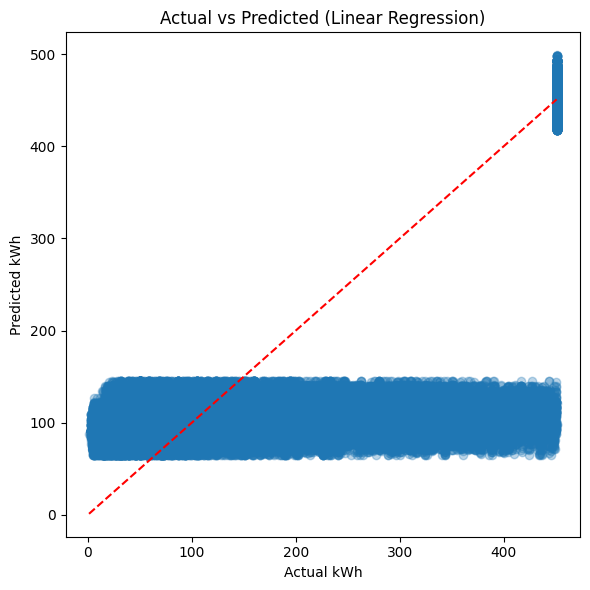

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = lin_model_scaled.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📈 Model Evaluation Results")
print(f"MAE  : {mae:,.3f}")
print(f"RMSE : {rmse:,.3f}")
print(f"R²   : {r2:,.3f}")

# Optional: quick comparison of actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual kWh")
plt.ylabel("Predicted kWh")
plt.title("Actual vs Predicted (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 2184115, number of used features: 26
[LightGBM] [Info] Start training from score 116.344449


C:\Users\Asus\PycharmProjects\NEDCO_data_viz_app\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


📈 LightGBM Model Results
MAE  : 57.878
RMSE : 77.355
R²   : 0.317


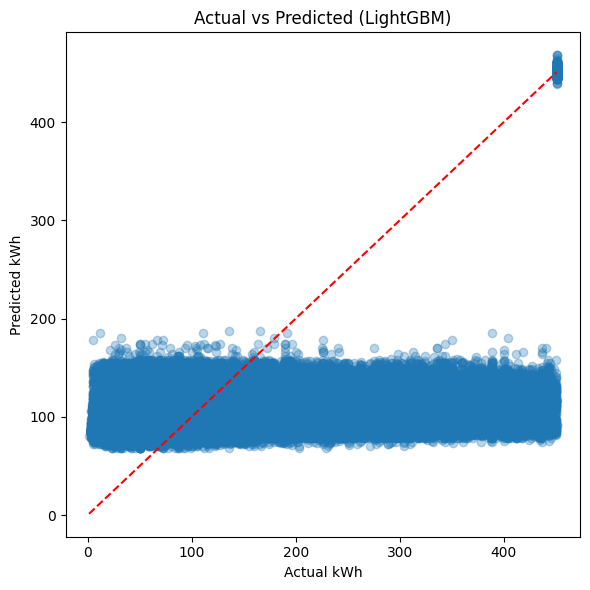

In [5]:
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Columns
cat_cols = ["loc", "res", "season"]
num_cols = ["is_capped", "month_num", "weekday", "is_weekend"]

# --- Preprocessing ---
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols)
])

# --- LightGBM model ---
lgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lgb.LGBMRegressor(
        n_estimators=300,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# Train
lgb_model.fit(X_train, y_train)

# Evaluate
y_pred = lgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📈 LightGBM Model Results")
print(f"MAE  : {mae:,.3f}")
print(f"RMSE : {rmse:,.3f}")
print(f"R²   : {r2:,.3f}")

# Optional quick scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual kWh")
plt.ylabel("Predicted kWh")
plt.title("Actual vs Predicted (LightGBM)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


In [10]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Columns
cat_cols = ["loc", "res", "season"]
num_cols = ["is_capped", "month_num", "weekday", "is_weekend"]

# Ensure categorical columns are of type 'category'
for c in ["loc", "res", "season"]:
    X_train[c] = X_train[c].astype("category")
    X_test[c] = X_test[c].astype("category")


# Datasets
lgb_train = lgb.Dataset(X_train[cat_cols + num_cols], label=y_train, categorical_feature=cat_cols)
lgb_test = lgb.Dataset(X_test[cat_cols + num_cols], label=y_test, categorical_feature=cat_cols)

# Parameters
params = {
    "objective": "regression",
    "metric": ["mae", "rmse"],
    "learning_rate": 0.1,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "verbose": -1,
    "seed": 42
}

# --- Train (new API: use callbacks for early stopping + logging) ---
model = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=300,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=50)
    ]
)

# --- Predict & Evaluate ---
y_pred = model.predict(X_test[cat_cols + num_cols])

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📈 LightGBM (native categorical) Results")
print(f"MAE  : {mae:,.3f}")
print(f"RMSE : {rmse:,.3f}")
print(f"R²   : {r2:,.3f}")


Training until validation scores don't improve for 30 rounds
[50]	training's l1: 58.0134	training's rmse: 77.4198	valid_1's l1: 57.9896	valid_1's rmse: 77.3622
[100]	training's l1: 57.8963	training's rmse: 77.4022	valid_1's l1: 57.8771	valid_1's rmse: 77.3527
Early stopping, best iteration is:
[92]	training's l1: 57.8955	training's rmse: 77.4034	valid_1's l1: 57.876	valid_1's rmse: 77.3534
📈 LightGBM (native categorical) Results
MAE  : 57.876
RMSE : 77.353
R²   : 0.317


In [11]:
import numpy as np

# add sin/cos encodings of month
X_train = X_train.copy(); X_test = X_test.copy()
for df_ in (X_train, X_test):
    df_["month_sin"] = np.sin(2*np.pi*df_["month_num"]/12.0)
    df_["month_cos"] = np.cos(2*np.pi*df_["month_num"]/12.0)

num_cols_plus = ["is_capped", "month_num", "weekday", "is_weekend", "month_sin", "month_cos"]
cat_cols = ["loc", "res", "season"]

# ensure categoricals use pandas 'category'
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_test[c]  = X_test[c].astype("category")


In [12]:
for df_ in (X_train, X_test):
    df_["loc_res"] = (df_["loc"].astype(str) + "|" + df_["res"].astype(str)).astype("category")

cat_cols_plus = cat_cols + ["loc_res"]


In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

train_cols = cat_cols_plus + num_cols_plus

# datasets
lgb_train = lgb.Dataset(X_train[train_cols], label=y_train, categorical_feature=cat_cols_plus)
lgb_valid = lgb.Dataset(X_test[train_cols],  label=y_test,  categorical_feature=cat_cols_plus)

params = {
    "objective": "regression",
    "metric": ["l1","l2"],          # MAE, MSE
    "learning_rate": 0.08,
    "num_leaves": 63,               # a bit more expressive
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "min_data_in_leaf": 200,        # prevents overfit, speeds up
    "verbose": -1,
    "seed": 42,
}

model = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    num_boost_round=400,
    callbacks=[lgb.early_stopping(stopping_rounds=40),
               lgb.log_evaluation(period=50)]
)

# evaluate
pred = model.predict(X_test[train_cols])
mae  = mean_absolute_error(y_test, pred)
rmse = np.sqrt(((y_test - pred)**2).mean())
r2   = r2_score(y_test, pred)

print(f"MAE: {mae:,.3f} | RMSE: {rmse:,.3f} | R²: {r2:,.3f}")


Training until validation scores don't improve for 40 rounds
[50]	training's l1: 58.1437	training's l2: 5993.61	valid_1's l1: 58.1272	valid_1's l2: 5986.07
[100]	training's l1: 57.8842	training's l2: 5989.18	valid_1's l1: 57.8747	valid_1's l2: 5983.76
Early stopping, best iteration is:
[88]	training's l1: 57.8923	training's l2: 5989.54	valid_1's l1: 57.8809	valid_1's l2: 5983.63
MAE: 57.881 | RMSE: 77.354 | R²: 0.317
